<a href="https://colab.research.google.com/github/grzabrodskiy/ImageRec/blob/main/src/FERProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to Facial Emotion Recognition (FER) Notebook

---



# Section A. Preparation

Connecting to Google Colab and Preparing data files

In [ ]:
import torch
import os
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Mounted at /content/drive


In [ ]:
#let's make sure we are on GPU

torch.cuda.is_available()

True

In [ ]:
print(device)

cuda:0


Setting up data path - all the data will be contained there

In [ ]:
DATA_FILE_COMPRESSED = "drive/My Drive/School/CW_Dataset.zip"
VIDEO_FILE = "drive/My Drive/School/video.mp4"

#DATA_PATH = "drive/My Drive/School/CW_Dataset"
CW_DATA_PATH = 'CW/'

Extracting data from CW_Dataset.zip file

In [ ]:
# Copy it to Colab
!cp '{DATA_FILE_COMPRESSED}' .

# Unzip it (removing useless files stored in the zip)
!unzip -q -o CW_Dataset.zip -d '{CW_DATA_PATH}'


In [ ]:
!cp '{DATA_FILE_COMPRESSED}' '{CW_DATA_PATH}/video.mp4'


Section 2. Preparing the environment

Importing basic libraries and setting up priniting params

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pylab import rcParams
import random
import pprint
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import time
import copy
import shutil
from torchvision.utils import make_grid


%matplotlib inline

rcParams['figure.figsize'] = 40, 40
pp = pprint.PrettyPrinter(indent=4)


Basic parameters we use throughout the notebook

In [ ]:
# Seven human emotions we will be recognizing
CLASS_MAP = {'Surprise': 1, 'Fear': 2, 'Disgust': 3, 'Happiness': 4, 'Sadness': 5, 'Anger': 6, 'Neutral': 7}
CLASS_NAMES = list(CLASS_MAP.keys())
CLASS_NUM = len(CLASS_NAMES) # number of features
# size of the image files
ROWS = 100
COLS = 100
# color channels (for non-gray images)
CHANNELS = 3

print(CLASS_NAMES)




['Surprise', 'Fear', 'Disgust', 'Happiness', 'Sadness', 'Anger', 'Neutral']


# Models

We will be using to libraries for CNN (PyTorch) and non-CNN (SciKit Learn) models, therefore we will need to load data for both.

The images for training and testing will be arrangled in 



```
train/sorted/
val/sorted/
test/sorted/
```



subdirectories respectively



---




In [ ]:
files = {}
for t in ['test', 'train', 'val']:
  for n in range (0, 7):
    dirpath = f'{CW_DATA_PATH}/{t}/sorted/' + CLASS_NAMES[n]
    if os.path.exists(dirpath) and os.path.isdir(dirpath):
      shutil.rmtree(dirpath)
    os.makedirs(dirpath, exist_ok=True)

Separating some of the train data for validation 

In [ ]:
VALIDATION_DATA_SIZE = 0.2 # upercent value of train data for validation


In [ ]:
for t in ['test', 'train']:
  files[t] = np.genfromtxt(f'{CW_DATA_PATH}/labels/list_label_{t}.txt',dtype='str')

  for fl in files[t]:
    if fl[0].endswith('.jpg'):
      if (t == 'train') and (random.uniform(0, 1) < VALIDATION_DATA_SIZE):
        shutil.copy2(f'{CW_DATA_PATH}/{t}/' + fl[0][:-4] + '_aligned.jpg', f'{CW_DATA_PATH}/val/sorted/' + CLASS_NAMES[int(fl[1])-1] + '/' + fl[0][:-4] +  '_aligned.jpg')
      else:
        shutil.copy2(f'{CW_DATA_PATH}/{t}/' + fl[0][:-4] + '_aligned.jpg', f'{CW_DATA_PATH}/{t}/sorted/' + CLASS_NAMES[int(fl[1])-1] + '/' + fl[0][:-4] +  '_aligned.jpg')




---


#Section B. PyTorch CNN modelling

Setting up data transformers

Train pipeline:
- Resized crop 
- Grayscale
- Horizontal flip

Val, Test:
Minimal adjustments

In [ ]:
data_transforms = {
  
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.Grayscale(num_output_channels=3),
        transforms.RandomHorizontalFlip(),
        
        transforms.ToTensor(),
        transforms.Normalize(0.5, 0.5)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(0.5, 0.5, inplace=True)
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(0.5, 0.5, inplace=True)
    ]),
}

Loading data into dataloaders 

In [ ]:
image_dataset = {}
dataloader = {}
for t in ['test', 'train', 'val']:

  image_dataset[t] = datasets.ImageFolder(f'{CW_DATA_PATH}/{t}/sorted', data_transforms[t])

  dataloader[t] = torch.utils.data.DataLoader(image_dataset[t], batch_size=4,
                                             shuffle=True, num_workers=2)
            

Split the validation data

In [ ]:
#total_size = len(img_data['train'])
#val_size = int(len(img_data['train']) * VALIDATION_DATA_SIZE)
#train_size = total_size - val_size

#img_data['train'], img_data['val'] = torch.utils.data.random_split(img_data['train'], [train_size, val_size])

#dataloader['train'] = torch.utils.data.DataLoader(img_data['train'], batch_size=1, num_workers=0, shuffle=True)
#dataloader['val'] = torch.utils.data.DataLoader(img_data['val'], batch_size=1, num_workers=0, shuffle=False)



In [ ]:
dataset_sizes = {x: len(image_dataset[x]) for x in ['train', 'test', 'val']}
print(dataset_sizes)
class_names = image_dataset['train'].classes
print(class_names)

{'train': 9785, 'test': 3068, 'val': 2486}
['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness', 'Surprise']


Displaying some images

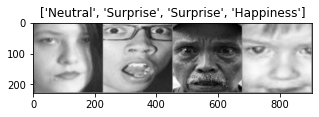

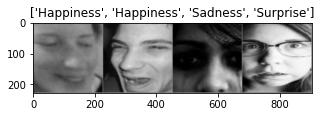

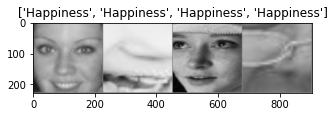

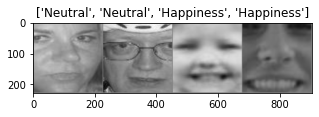

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.asarray(0.5) * inp + np.asarray(0.5)
    inp = np.clip(inp, 0, 1)    
    plt.imshow(inp)
    plt.title(title)


# Get a batch of training data
for i in range (1, 5):
  inputs, classes = next(iter(dataloader['train']))

  # Make a grid from batch
  out = torchvision.utils.make_grid(inputs)

  plt.figure(figsize=(5, 10))
  imshow(out, title=[class_names[x] for x in classes])
  plt.show()

Training the model

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1} out of {num_epochs}")

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloader[phase]:
                # move data to GPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # update learning rate with scheduler
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f"{phase} loss: {epoch_loss:.4f} acc: {epoch_acc:.4f}")

            # deep copy the model with best accuracy on validation set
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best val acc: {best_acc:4f}")

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing model predictions

In [ ]:
def visualize_model_nn(model, num_images=4):
    was_training = model.training
    model.eval()
    images_so_far = 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images, 4, images_so_far)
                ax.axis('off')
               
                imshow(inputs.cpu().data[j]) # move back the data to the CPU for visualisation
                ax.set_title(f"{class_names[preds[j]]}", fontsize=24)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Set up model params

In [ ]:
MODEL1_LEARNING_RATE = 0.001
MODEL1_MOMENTUM = 0.9
MODEL1_GAMMA = 0.1 # LR factor
MODEL1_STEP_SIZE = 7 #number of epoch to decay LR
MODEL1_NUM_EPOCHS = 1#0

Finetuning the model based on Resnet18 


In [ ]:
# download pretrained model
model_ft = models.resnet18(pretrained=True)
# connect our model with pretrained layers
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, CLASS_NUM)
# load the model into GPU, setup parameters
print(device)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=MODEL1_LEARNING_RATE, momentum=MODEL1_MOMENTUM)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=MODEL1_STEP_SIZE, gamma=MODEL1_GAMMA)

cuda:0


Train and validate

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=MODEL1_NUM_EPOCHS)

Epoch 1 out of 1
train loss: 1.6271 acc: 0.4219
val loss: 1.2611 acc: 0.5893

Training complete in 0m 46s
Best val acc: 0.589300


Visualizing some images

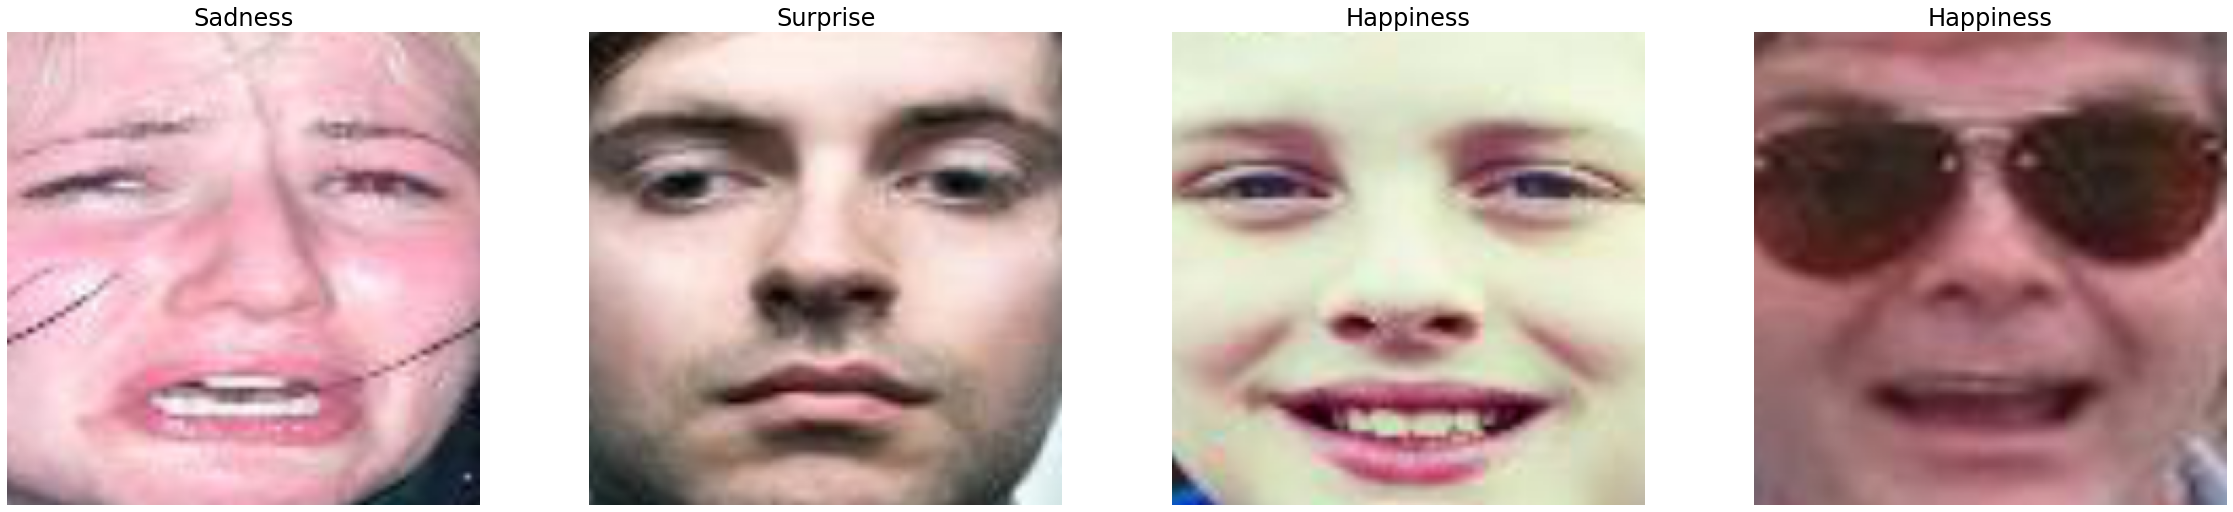

In [ ]:
fig = plt.figure()
visualize_model_nn(model_ft)
plt.show()

In [ ]:
running_loss = running_corrects = 0
y_pred = []
y_true = []
for inputs, labels in dataloader['test']:
  # move data to GPU
  inputs = inputs.to(device)
  labels = labels.to(device)
 
  # track history if only in train
  with torch.set_grad_enabled(False):
    outputs = model_ft(inputs)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

                    
    # statistics
    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)

    outputs1 = preds.data.cpu().numpy()
    y_pred.extend(outputs1) # Save Prediction
        
    labels1 = labels.data.cpu().numpy()
    y_true.extend(labels1) # Save Actuals

    
epoch_loss = running_loss / dataset_sizes['test']
epoch_acc = running_corrects.double() / dataset_sizes['test']

print(f"Test loss: {epoch_loss:.4f} acc: {epoch_acc:.4f}")


Test loss: 1.2379 acc: 0.5935


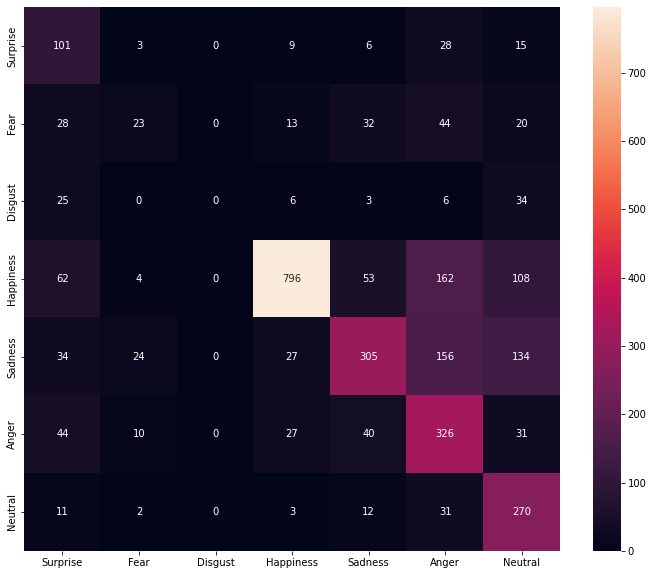

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

cf_matrix = confusion_matrix(y_true, y_pred)
df = pd.DataFrame(cf_matrix, index = [i for i in CLASS_NAMES],
                     columns = [i for i in CLASS_NAMES])
plt.figure(figsize = (12,10))
sn.heatmap(df, annot=True, fmt = '')




---





---


#Section C. Skimage modelling


Loading data into dataloaders



In [ ]:
from skimage.color import rgb2gray
from skimage.feature import hog

img_list = dict()
labels = dict()
num_images = dict()

for t in ['train', 'test', 'val']:

  img_data_list = []
  labels_list = []
  for label in CLASS_NAMES:
    if label == '': 
      continue
    
    for img in os.listdir(f'{CW_DATA_PATH}/{t}/sorted/{label}'):
      input_img = cv2.imread(f'{CW_DATA_PATH}/{t}/sorted/{label}/{img}')
      img_data_list.append(input_img)
      labels_list.append(label)

  img_list[t] = img_data_list
  labels[t] = np.array(labels_list)

print (labels['test'])


['Surprise' 'Surprise' 'Surprise' ... 'Neutral' 'Neutral' 'Neutral']


In [ ]:


print (len(img_list))

3


#Transformers

In [ ]:
from skimage.color import rgb2gray
from skimage.feature import hog

img_data = dict()

for t in ['train', 'test', 'val']:
  img_list_x = []
  #img_list_hog = []
  #img_list_scale = []
  for img in img_list[t]:
    ### Gray_transformer:
    img_x = rgb2gray(img)

    ### Hog_transformer:
    #img_x = hog(img_x,
    #                  orientations=9,
    #                  pixels_per_cell=[2,2],
    #                  cells_per_block=[1,1],
    #                  block_norm='L2-Hys')
    
    ### Scale_transformer_pipeline:
    #img_x = cv2.resize(img_x,(ROWS//2,COLS//2))

    img_list_x.append(img_x)

  
  img_data[t] = np.array(img_list_x).astype('float32') /255.0
  img_data[t] = img_data[t].reshape((len(img_data[t]), -1)) # Flatten the images

  num_images[t] = img_data[t].shape[0]

# merge train and val sets - will be doing cross validation
img_data['train'] = np.concatenate((img_data['train'],img_data['val']), axis = 0)
labels['train'] = np.concatenate((labels['train'],labels['val']), axis = 0)


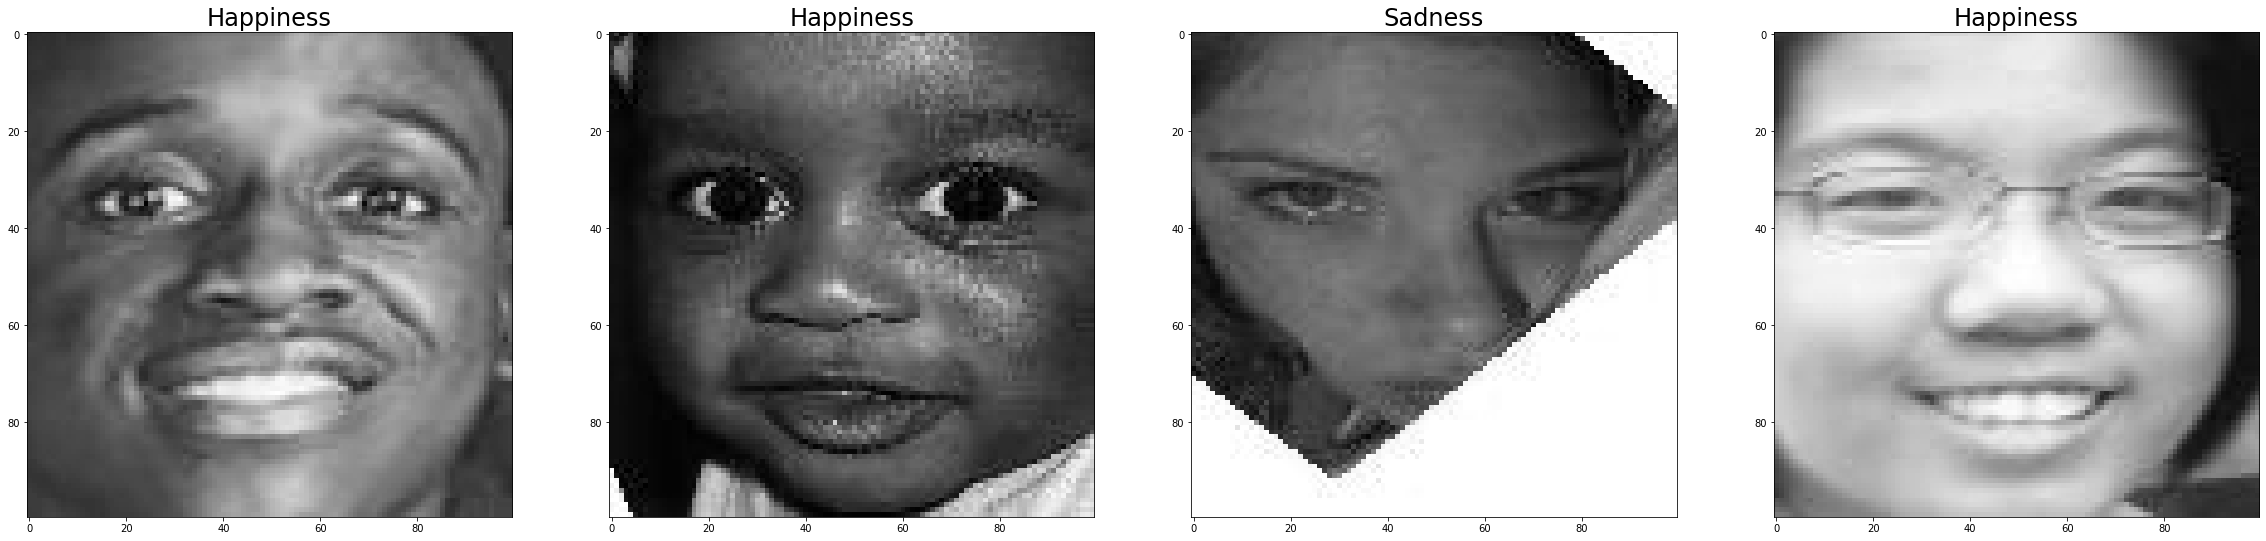

In [ ]:
NUM_SAMPLES = 4
# Create a display of samples
fig, axs = plt.subplots(1, NUM_SAMPLES)

train_data = img_data['train']

for i in range(NUM_SAMPLES):
  #for j in range(1):
    index = random.randint(0, len(train_data)-1) # pick a random index
    img = train_data[index]
    img = img.reshape(COLS, ROWS, 1) #channels
    label = labels['train'][index]
    axs[i].imshow(img[:,:,0])
    axs[i].set_title(label, fontsize = 24)

#Classifiers

Prepare the report

In [ ]:
from sklearn import svm, metrics
from sklearn.metrics import confusion_matrix
from sklearn.utils import validation


def report(classifier, expected, predicted):
  print("Classification report for classifier %s:\n%s\n"
        % (classifier, metrics.classification_report(expected, predicted)))

  cm = confusion_matrix(labels['test'], predicted)
  plt.matshow(cm)
  plt.title('Confusion Matrix')
  plt.colorbar()
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')
  plt.xticks(ticks=range(0,7), labels=list(CLASS_MAP.keys()))
  plt.yticks(ticks=range(0,7), labels=list(CLASS_MAP.keys()))
  plt.show()

In [ ]:
#from sklearn.utils import validation
#from sklearn import svm, metrics
#
#classifier1 = svm.SVC(gamma=0.001, kernel='linear', C=1) 
#classifier1.fit(img_data['train'], labels['train'])

# Now predict on the test data
#predicted1 = classifier1.predict(img_data['test'])
#expected1 = labels['test']

#report(classifier1, expected1, predicted1)

#Training

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier SGDClassifier(early_stopping=True, random_state=42):
              precision    recall  f1-score   support

       Anger       0.00      0.00      0.00       162
     Disgust       0.00      0.00      0.00       160
        Fear       0.50      0.01      0.03        74
   Happiness       0.72      0.66      0.69      1185
     Neutral       0.56      0.25      0.35       680
     Sadness       0.22      0.71      0.33       478
    Surprise       0.73      0.24      0.36       329

    accuracy                           0.45      3068
   macro avg       0.39      0.27      0.25      3068
weighted avg       0.53      0.45      0.44      3068




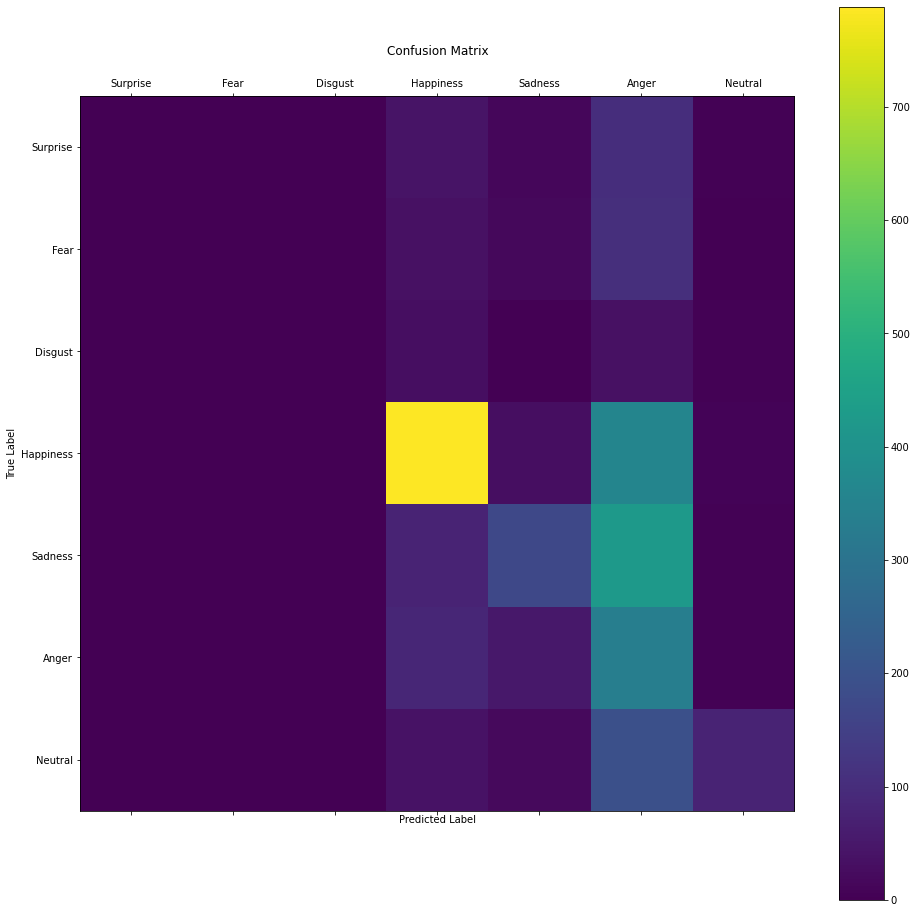

In [ ]:
from sklearn.linear_model import SGDClassifier

classifier2 = SGDClassifier(random_state=42, max_iter=1000, 
                            tol=1e-3, early_stopping=True, validation_fraction=0.1)

classifier2.fit(img_data['train'], labels['train'])
predicted2 = classifier2.predict(img_data['test'])
expected2 = labels['test']

report(classifier2, expected2, predicted2)


In [ ]:
#from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
#from time import time
#
#param_grid = {
#    "average": [True, False]
    #"l1_ratio": np.linspace(0, 1, num=2)
    #"alpha": np.power(10, np.arange(-2, 1, dtype=float)),
#}
#start1 = time()
#grid_search = GridSearchCV(classifier2, param_grid=param_grid)
#grid_search.fit(img_data['train'], labels['train'])
#print(
#    "GridSearchCV took %.2f seconds for %d candidate parameter settings."
#    % (time() - start1, len(grid_search.cv_results_["params"]))
#)
#print(grid_search.cv_results_)


Classification report for classifier RandomForestClassifier(random_state=42):
              precision    recall  f1-score   support

       Anger       0.67      0.12      0.21       162
     Disgust       0.50      0.01      0.01       160
        Fear       0.88      0.19      0.31        74
   Happiness       0.65      0.91      0.76      1185
     Neutral       0.52      0.70      0.60       680
     Sadness       0.43      0.24      0.31       478
    Surprise       0.69      0.37      0.48       329

    accuracy                           0.59      3068
   macro avg       0.62      0.36      0.38      3068
weighted avg       0.59      0.59      0.54      3068




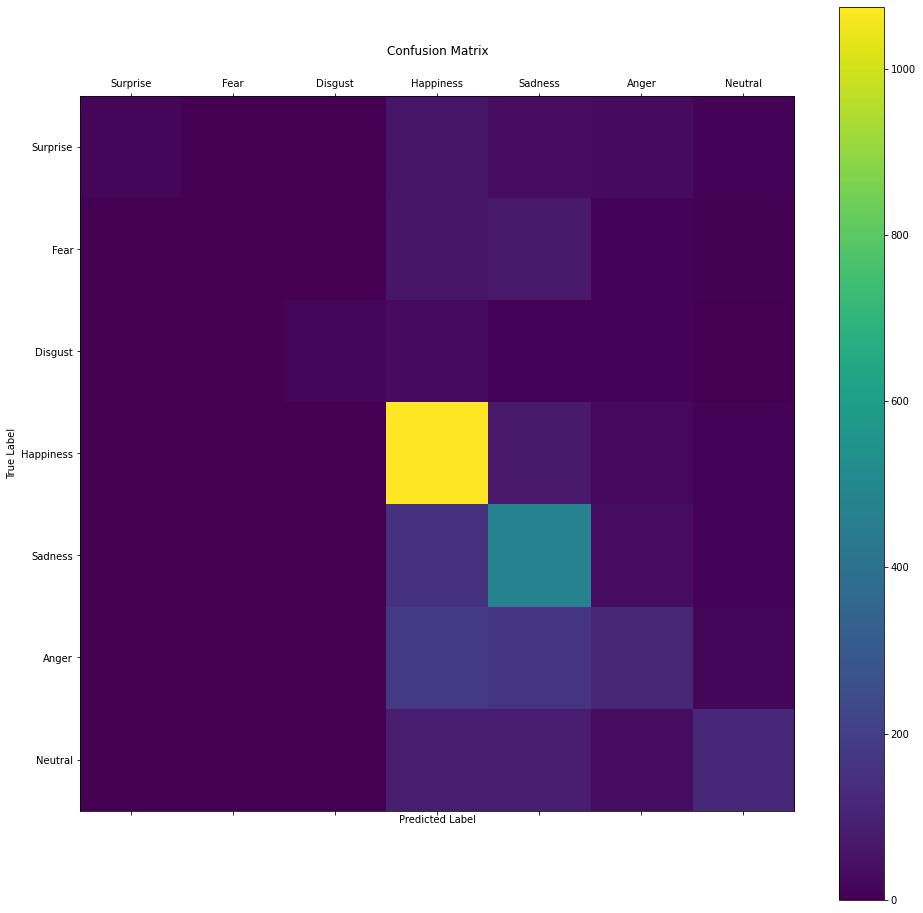

In [ ]:
from sklearn.ensemble import RandomForestClassifier

classifier3 = RandomForestClassifier(random_state=42)

classifier3.fit(img_data['train'], labels['train'])
predicted3 = classifier3.predict(img_data['test'])
expected3 = labels['test']

report(classifier3, expected3, predicted3)

## EmotionRecognition function

Takes parameters:
  `model` - one of `cnn, svm, randomforest`
  `(opt) num` - number of images to display

In [ ]:
def EmotionRecognition(model, num = 4):

    if model == 'cnn':
      visualize_model_nn(model_ft)
      return
    elif model == 'svm':
      pred_ = predicted2
    elif model == 'randomforest':
      pred_ = predicted2
    else: 
      print('unknown model\nchoose from cnn|svm|randomforest')
      return

# Create a display of samples
    fig, axs = plt.subplots(1, num)

    train_data = img_data['test']

    for i in range(NUM_SAMPLES):
      #for j in range(1):
        index = random.randint(0, len(train_data)-1) # pick a random index
        img = train_data[index]
        img = img.reshape(COLS, ROWS, 1) #channels
        label = expected3[index]
        axs[i].axis('off')
        axs[i].imshow(img[:,:,0])
        axs[i].set_title(label, fontsize = 24)

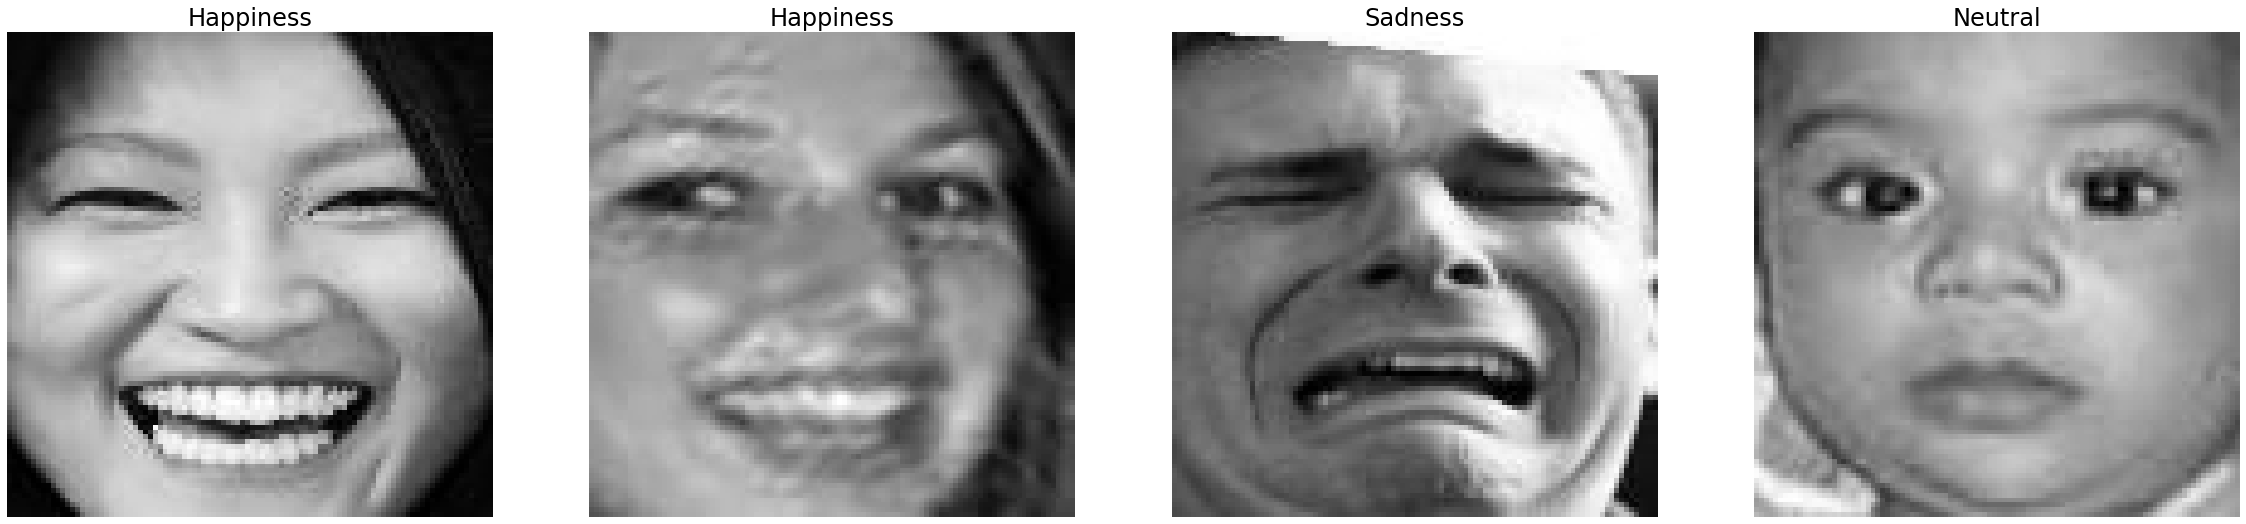

In [ ]:
EmotionRecognition('randomforest')

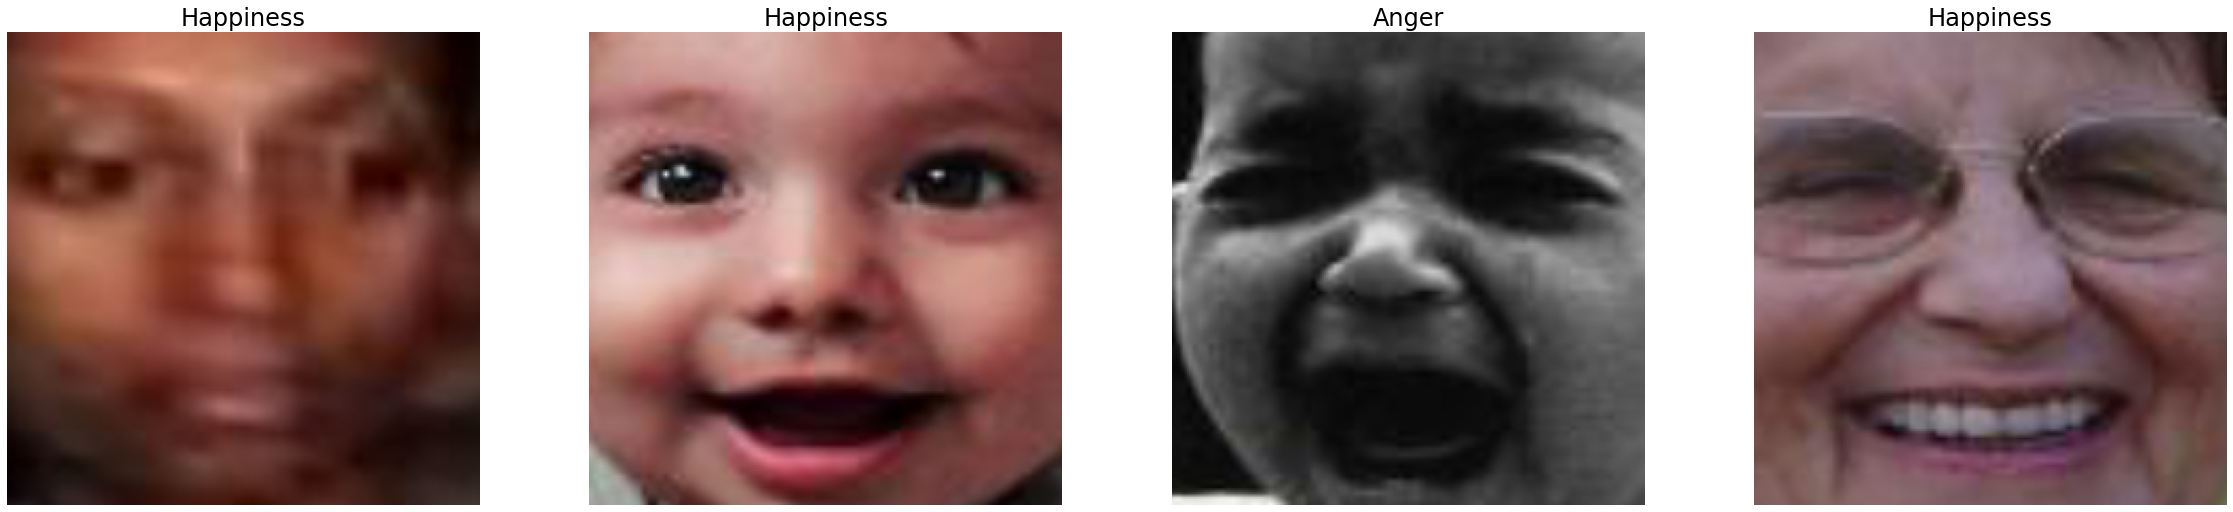

In [ ]:
EmotionRecognition('cnn')

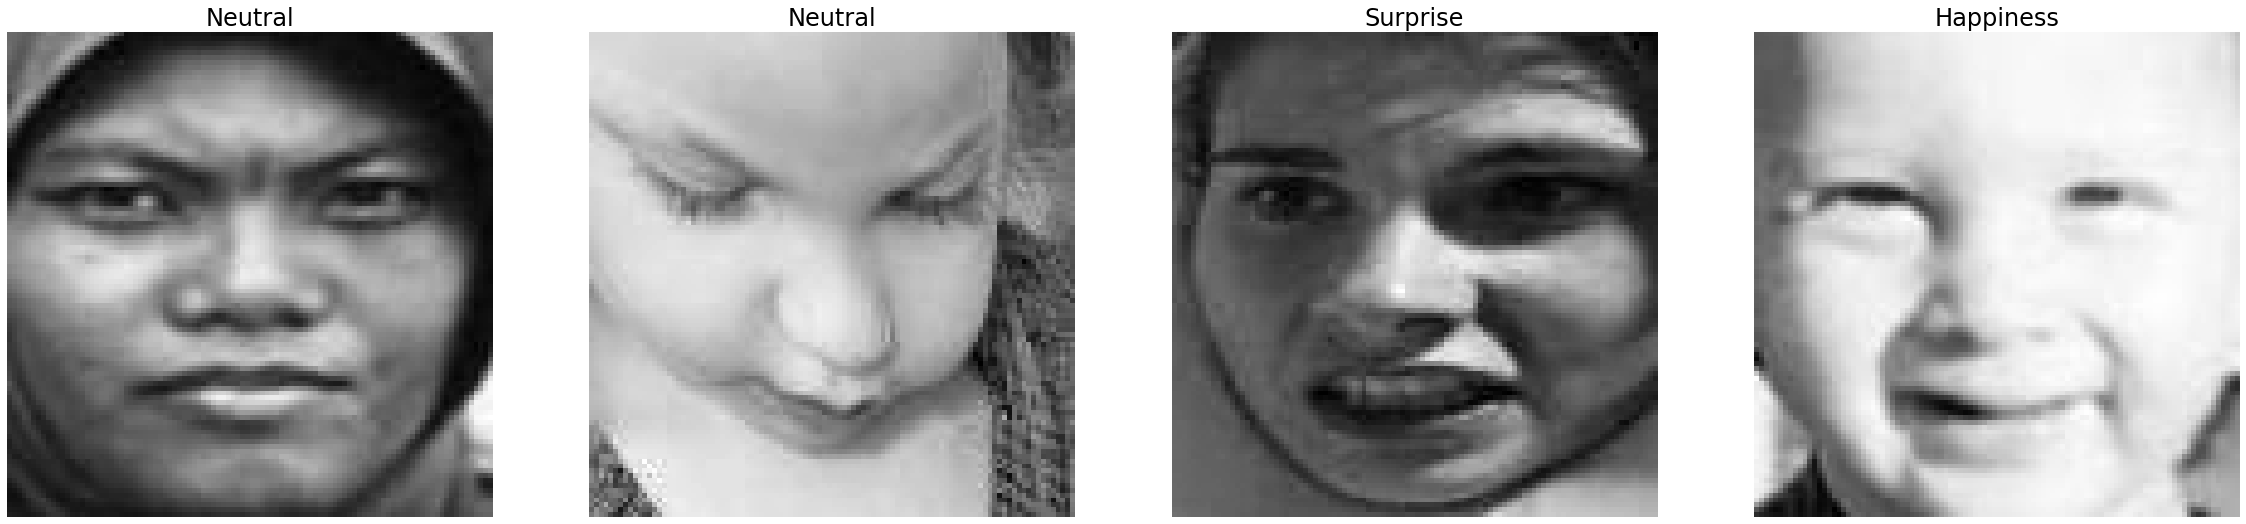

In [ ]:
EmotionRecognition('svm')

##Reading video

In [ ]:
!cp '{VIDEO_FILE}' 'CW/video.mp4'
 

In [ ]:
import cv2
from skimage import data
from skimage.feature import Cascade
import matplotlib.pyplot as plt
from matplotlib import patches
from skimage.transform import rescale, resize, downscale_local_mean
from skimage import color
from PIL import Image



Loading a sample video

In [ ]:
def loadVideo(path, display = True):
  vidcap = cv2.VideoCapture(path)
  success,image = vidcap.read()
  if success:
    if display:
      print('Video loaded: ', path) 
  else: 
    return [], 0
  count = 0
  frames = []
  while success:
    #cv2.imwrite("CW/frame%d.jpg" % count, image)     # save frame as JPEG file      
    success,image = vidcap.read()
    frames.append(image)
    #print('Reading frame: ', count, success)
    count += 1

  if display:
    print ('Saved frames ', count)
  vidcap.release()
  cv2.destroyAllWindows()
  return frames, count

Video loaded:  CW/video.mp4
Saved frames  206


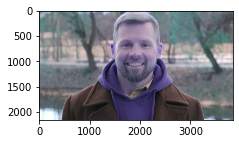

In [ ]:
# free download from ttps://www.pexels.com/video/
frames, count = loadVideo('CW/video.mp4')
if len(frames) > 0:
  frame = frames[0]
  plt.figure(figsize = (20,2))

  plt.imshow(frame)

In [ ]:
def select_face(frame, display = True):
  # Load the trained file from the module root.
  trained_file = data.lbp_frontal_face_cascade_filename()
  # Initialize the detector cascade.
  detector = Cascade(trained_file)
  detected = detector.detect_multi_scale(img=frame,
                                        scale_factor=1.2,
                                        step_ratio=1,
                                        min_size=(400, 400),
                                        max_size=(1000, 1000))
  if display:
    plt.figure(figsize = (20,2))
    plt.imshow(frame)
    img_desc = plt.gca()
    #plt.set_cmap('gray')
    for patch in detected:
        img_desc.add_patch(
            patches.Rectangle(
                (patch['c'], patch['r']),
                patch['width'],
                patch['height'],
                fill=False,
                color='r',
                linewidth=2
            )
        )
    plt.show()
  return detected

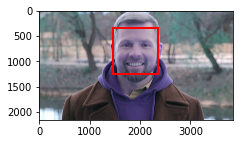

In [ ]:
detected = select_face(frame)

In [ ]:
def extract_face(frame, display = True):

  detected = select_face(frame, False)
  if (len(detected)<=0):
    return frame

  faces = []
  for face in detected:
    x, y = face['r'], face['c']
    w, h = face['width'], face['height']
    img_face = frame[x:x+w, y:y+h]
    image_resized = resize(img_face, (100, 100),
                        anti_aliasing=True)
    faces.append(image_resized)
    if display:
      plt.figure(figsize = (20,3))
      plt.imshow(image_resized)
  return faces

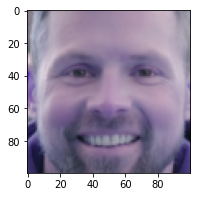

In [ ]:
faces = extract_face(frame)

In [ ]:
def tensorize(frame):
  transform = transforms.Compose([
      transforms.PILToTensor()
  ])
  im = Image.fromarray(np.uint8(color.gray2rgb(frame)*255))
  img_tensor = transform(im).cuda()
  #print(img_tensor.size())
  #print(img_tensor)
  img_tensor.resize_(1, 3, 100, 100)
  #print(img_tensor)
  a = model_ft(img_tensor.float())
  return a

In [ ]:
def predict_face(frame, model = 'cnn', display = True):
  
  if model == 'svm':
    cf = classifier2
  elif model == 'randomforest':
    cf = classifier3
  faces = extract_face(frame, display)
  face_img = faces[0]
  face_img = rgb2gray(faces[0])

  if model == 'cnn':
    a = tensorize(face_img)
    _, preds = torch.max(a, 1)
    return CLASS_NAMES[preds]


  data = np.array([face_img]).astype('float32') /255.0
  data = data.reshape((len(data), -1)) # Flatten the images
  predicted = cf.predict(data)
  return predicted[0]


Happiness


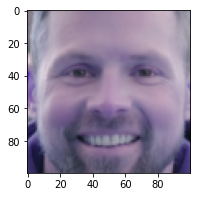

In [ ]:
print(predict_face(frame)) ## default is CNN

Happiness


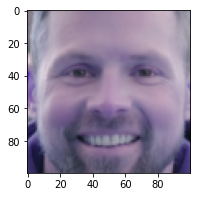

In [ ]:
print(predict_face(frame, 'svm'))

Happiness


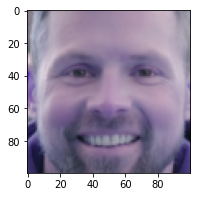

In [ ]:
print(predict_face(frame, 'randomforest'))

##EmotionRecognitionVideo function

In [ ]:
def EmotionRecognitionVideo (path, model = 'cnn'):
  frames, count = loadVideo(path, False)
  if (count == 0):
    print('video cannot be loaded:', path)
    return

  frame = frames[0] # take the first frame

  print(predict_face(frame, model))



Happiness


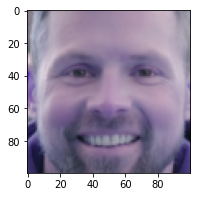

In [ ]:
EmotionRecognitionVideo('CW/video.mp4')